# Paper Replication: (Re-)Imag(in)ing Price Trends

### Test the network

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [12]:
# import libraries
from torchcam.methods import GradCAM
import pandas as pd
import numpy as np
import os.path as op
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [13]:
# define constants
DATA_ROOT = '../../datasets/price_trends/monthly_20d'  # change this to yours

# the two below are given by https://dachxiu.chicagobooth.edu/download/img_demo.html
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

# these below are all from the paper
YEAR_START = 1993
YEAR_END = 2019    # inclusive
YEAR_SPLIT = 2000  # 1993-1999 for training/validation, 2000-2019 for testing

VALIDATION_PORTION = 0.3
BATCH_SIZE = 128

# other constants
DAYS_OF_RET = 5
NUM_WORKERS = 0
MAX_EPOCHS = 50

In [14]:
class OHLC20DaysDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, year):
        images_path = op.join(data_root, f'20d_month_has_vb_[20]_ma_{year}_images.dat')
        images = np.memmap(images_path, dtype=np.uint8, mode='r')
        images = images.reshape((-1, 1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

        labels_path = op.join(data_root, f'20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather')
        labels_df = pd.read_feather(labels_path)
        labels = labels_df[f'Ret_{DAYS_OF_RET}d']

        missing = labels.isna()
        images = images[~missing]
        labels = labels[~missing]
        print(f'year {year}: {sum(missing)} data with missing label ignored')

        self.images = torch.tensor(images, dtype=torch.float)
        self.labels = torch.tensor(labels > 0, dtype=torch.long)
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return self.images.size(0)

In [15]:
datasets = []

for year in range(YEAR_SPLIT, YEAR_END+1):
    dataset = OHLC20DaysDataset(DATA_ROOT, year)
    datasets.append(dataset)

test_data = torch.utils.data.ConcatDataset(datasets)

year 2000: 394 data with missing label ignored
year 2001: 346 data with missing label ignored
year 2002: 261 data with missing label ignored
year 2003: 239 data with missing label ignored
year 2004: 208 data with missing label ignored
year 2005: 231 data with missing label ignored
year 2006: 233 data with missing label ignored
year 2007: 326 data with missing label ignored
year 2008: 378 data with missing label ignored
year 2009: 180 data with missing label ignored
year 2010: 185 data with missing label ignored
year 2011: 170 data with missing label ignored
year 2012: 173 data with missing label ignored
year 2013: 119 data with missing label ignored
year 2014: 131 data with missing label ignored
year 2015: 167 data with missing label ignored
year 2016: 214 data with missing label ignored
year 2017: 182 data with missing label ignored
year 2018: 163 data with missing label ignored
year 2019: 136 data with missing label ignored


In [16]:
class CNN20Days(nn.Module):
    # expected input tensor size: (1, 64, 60)
    def __init__(self):
        super(CNN20Days, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,3),  # output shape:
                      stride=(3,1), dilation=(2,1), padding=(4,1)),        # (64, 22, 60)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1)),                               # (64, 11, 60)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,3),
                      padding=(2,1)),                                      # (128, 11, 60)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1), ceil_mode=True),               # (128, 6, 60)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,3),
                      padding=(2,1)),                                      # (256, 6, 60)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=(2,1)),                               # (256, 3, 60)
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256 * 3 * 60, 2)                               # (2,)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.dropout(x.flatten(1))
        x = self.fc(x)
        return x

model = CNN20Days()
model

CNN20Days(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(4, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fa

Load the test data

In [17]:
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS)

In [18]:
# load model parameter
model = CNN20Days()
path = f'checkpoint.{DAYS_OF_RET}ret.best.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

  0%|          | 0/11701 [00:00<?, ?it/s]


1
2
3
4
5
6
7
8
9
10


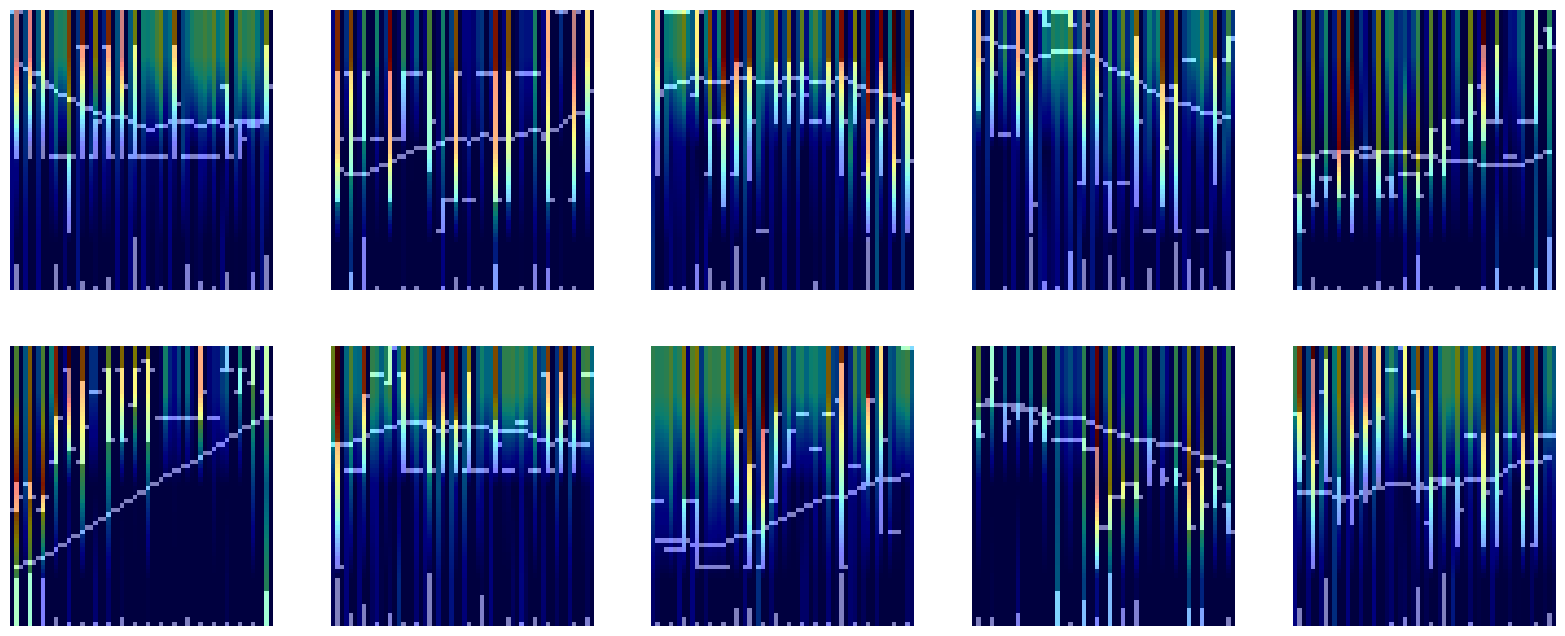

In [20]:
model.to(device)
model.eval()

cam = GradCAM(model=model, target_layer=model.block3[-1])

correct_images = []
correct_heatmaps = []
correct_labels = []

for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(True):
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
        for idx in correct_indices:
            if len(correct_images) < 10:
                cam_input = images[idx].unsqueeze(0)
                output_for_cam = model(cam_input)

                class_idx = preds[idx].item()
                scores = output_for_cam.squeeze()

                # Ensure 'scores' retains a batch dimension
                if scores.ndim == 1:
                    scores = scores.unsqueeze(0)  # Add a batch dimension if missing

                try:
                    cam_maps = cam(class_idx=class_idx, scores=scores)
                    if cam_maps:
                        # Handling potential list of CAM outputs
                        cam_map = cam_maps[0] if isinstance(cam_maps, list) else cam_maps
                        cam_map = cam_map.squeeze().cpu().numpy()
                        correct_images.append(cam_input)
                        correct_heatmaps.append(cam_map)
                        print(len(correct_images))
                except Exception as e:
                    print(f"Error processing GradCAM: {e}")
                
                if len(correct_images) >= 10:
                    break

        if len(correct_images) >= 10:
            break

# Visualization of results (example using matplotlib)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, (img, heatmap) in enumerate(zip(correct_images, correct_heatmaps)):
    heatmap = cv2.resize(heatmap, (60, 64))
    ax = axes[i // 5, i % 5]
    img = img.cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.axis('off')
plt.show()